### This is a PROMISE Software Engineering Repository data set made publicly available in order to encourage repeatable, verifiable, refutable, and/or improvable predictive models of software engineering.

If you publish material based on PROMISE data sets then, please
follow the acknowledgment guidelines posted on the PROMISE repository
web page http://promise.site.uottawa.ca/SERepository .

In [1]:
import math
from scipy.io import arff
from scipy.stats.stats import pearsonr
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, classification_report, r2_score
from sklearn.model_selection import LeaveOneOut 
from sklearn.cross_validation import cross_val_score, cross_val_predict

# Formatação mais bonita para os notebooks
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15,5)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_desharnais = pd.read_csv('../Datasets/02.desharnais.csv',  header=0)
df_desharnais.head()

,id,Project,TeamExp,ManagerExp,YearEnd,Length,Effort,Transactions,Entities,PointsNonAdjust,Adjustment,PointsAjust,Language
0,1,1,1,4,85,12,5152,253,52,305,34,302,1
1,2,2,0,0,86,4,5635,197,124,321,33,315,1
2,3,3,4,4,85,1,805,40,60,100,18,83,1
3,4,4,0,0,86,5,3829,200,119,319,30,303,1
4,5,5,0,0,86,4,2149,140,94,234,24,208,1


##  1.0. Data discovering

Regression Equations and Coefficient of determination (R2) values are given. The R2 value is for example 48.10 means that 48.10% of the variation in `Effort` can be explained by the independent variables.

In [3]:
r2_scores = []

def print_r2(independents_var_list, dependent_var):
    model = LinearRegression()
    for x in independents_var_list:
        independent_var = np.reshape(np.array(df_desharnais[x]), (len(df_desharnais[x]), 1))
        model.fit(independent_var, dependent_var) 
        model.predict(independent_var)
        r2_scores.append(model.score(independent_var,dependent_var))
        print("R-Squared coefficient of '{}' : {:.2f}".format(x,round(model.score(independent_var,dependent_var)*100, 2)))

effort = np.reshape(np.array(df_desharnais['Effort']), (len(df_desharnais['Effort']), 1)) 
print_r2(['Length','Transactions','Entities','PointsAjust','PointsNonAdjust'], effort)

R-Squared coefficient of 'Length' : 48.06
R-Squared coefficient of 'Transactions' : 33.86
R-Squared coefficient of 'Entities' : 26.04
R-Squared coefficient of 'PointsAjust' : 54.50
R-Squared coefficient of 'PointsNonAdjust' : 49.77


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


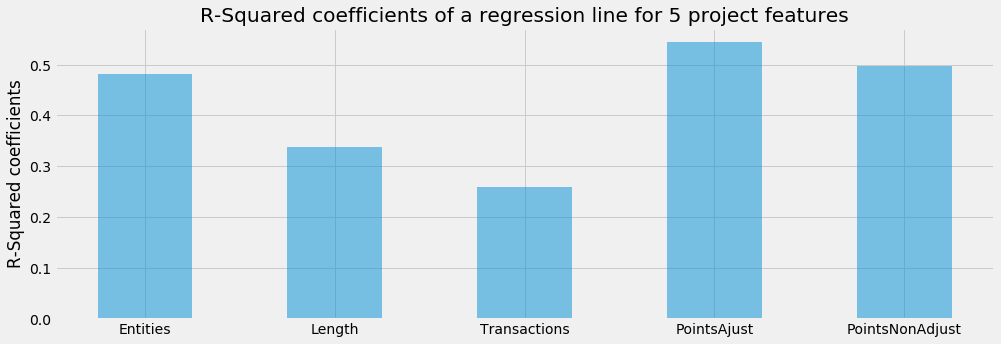

In [4]:
objects = ('Entities','Length','Transactions','PointsAjust','PointsNonAdjust')
y_pos = np.arange(len(objects))
width = 0.5
plt.bar(y_pos, r2_scores, width, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('R-Squared coefficients')
plt.title('R-Squared coefficients of a regression line for 5 project features')
 
plt.show()

According to results, only `PointsAjust` feature give acceptable `R2` values (an acceptable value of `R2 is ≥ 0.5`).


# 2.3. Feature Selection

## 2.3.1 Applying Wrapper - RFE

In [5]:
from sklearn.feature_selection import RFE
feature_names = df_desharnais.columns

array = df_desharnais.values
X = array[:,0:12]
Y = array[:,12]

# feature extraction
model = LinearRegression()
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Num Features: {}".format(fit.n_features_))
print("Selected Features: {}".format(fit.support_))
print("Feature Ranking: {}".format(fit.ranking_))
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), feature_names)))

Num Features: 3
Selected Features: [False False  True  True  True False False False False False False False]
Feature Ranking: [ 4  3  1  1  1  2 10  8  9  6  5  7]
[(1, 'ManagerExp'), (1, 'TeamExp'), (1, 'YearEnd'), (2, 'Length'), (3, 'Project'), (4, 'id'), (5, 'Adjustment'), (6, 'PointsNonAdjust'), (7, 'PointsAjust'), (8, 'Transactions'), (9, 'Entities'), (10, 'Effort')]


## 2.3.2 Applying PCA

Although instead, we could apply  F-Test(Filter Method), that is useful in feature selection as we get to know the significance of each feature in improving the model.

### 2.3.2.1 Standardize the Data
PCA is effected by scale so you need to scale the features in your data before applying PCA. Use StandardScaler to help you standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms. If you want to see the negative effect not scaling your data can have, scikit-learn has a section on the [effects of not standardizing your data](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py)

In [6]:
# Feature Extraction with PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load data
array = df_desharnais.values
X = array[:,0:12]
Y = array[:,12]

# Standardizing the features
X_std = StandardScaler().fit_transform(X)

# Fit the model and apply the dimensionality reduction.
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_std)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### 2.3.2.2 PCA Anlaysis

In [7]:
# summarize components
principalDf = pd.DataFrame(data = principalComponents, columns = ['princ. component 1', 'princ. component 2', 'princ. component 3'])
principalDf.head()


,princ. component 1,princ. component 2,princ. component 3
0,-0.348821,-2.074312,0.128298
1,-0.988526,-2.350327,2.094837
2,-2.837136,-1.481515,-2.053453
3,-1.167461,-2.077108,2.046859
4,-2.140270,-1.690845,1.835513


The explained variance tells how much information (variance) can be attributed to each of the principal components. This is important as while you can convert 8 dimensional space to 3 dimensional space, you lose some of the variance (information) when you do this. By using the attribute `explained_variance_ratio_`, you can see:
* The first principal component contains **35.2%** of the variance; 
* The second principal component contains **21.02%** of the variance;
* The third principal component contains **16.7%** of the variance. 

Together, the two components contain **73.10%** of the information.



In [8]:
print("Explained Variance:")  
print(pca.explained_variance_ratio_)

Explained Variance:
[0.4045841  0.17952519 0.11755507]


## 2.3.2 Applying Pearson’s correlation

In this section, the correlations between attributes of Desharnais dataset and software effort are analyzed and applicability of the regression analysis is examined. The correlation between two variables is a measure of how well the variables are related. The most common measure of correlation in statistics is the Pearson Correlation (or the Pearson Product Moment Correlation - PPMC) which shows the linear relationship between two variables. 

Pearson correlation coefficient analysis produces a result between `-1` and `1`. A result of `-1` means that there is a perfect negative correlation between the two values at all, while a result of `1` means that there is a perfect positive correlation between the two variables. 

Results between `0.5` and `1.0` indicate high correlation.Correlation coefficients are used in statistics to measure how strong a relationship is between two variables. There are several types of correlation coefficient. `Pearson’s correlation` (also called Pearson’s R) is a correlation coefficient commonly used in linear regression.

In [9]:
df_desharnais.corr()

,id,Project,TeamExp,ManagerExp,YearEnd,Length,Effort,Transactions,Entities,PointsNonAdjust,Adjustment,PointsAjust,Language
id,1.000000,1.000000,-0.006007,0.214294,0.096486,0.255187,0.126153,0.265891,0.028787,0.226076,-0.207774,0.202608,0.391475
Project,1.000000,1.000000,-0.006007,0.214294,0.096486,0.255187,0.126153,0.265891,0.028787,0.226076,-0.207774,0.202608,0.391475
TeamExp,-0.006007,-0.006007,1.000000,0.424687,-0.210335,0.143948,0.119529,0.103768,0.256608,0.203805,0.235629,0.222884,-0.079112
ManagerExp,0.214294,0.214294,0.424687,1.000000,-0.011519,0.211324,0.158303,0.138146,0.206644,0.207748,-0.066821,0.187399,0.205521
YearEnd,0.096486,0.096486,-0.210335,-0.011519,1.000000,-0.095027,-0.048367,0.034331,0.001686,0.028234,-0.056743,0.012106,0.342233
Length,0.255187,0.255187,0.143948,0.211324,-0.095027,1.000000,0.693280,0.620711,0.483504,0.723849,0.266086,0.714092,-0.023810
Effort,0.126153,0.126153,0.119529,0.158303,-0.048367,0.693280,1.000000,0.581881,0.510328,0.705449,0.463865,0.738271,-0.261942
Transactions,0.265891,0.265891,0.103768,0.138146,0.034331,0.620711,0.581881,1.000000,0.185041,0.886419,0.341906,0.880923,0.136778
Entities,0.028787,0.028787,0.256608,0.206644,0.001686,0.483504,0.510328,0.185041,1.000000,0.618913,0.234747,0.598401,-0.056439
PointsNonAdjust,0.226076,0.226076,0.203805,0.207748,0.028234,0.723849,0.705449,0.886419,0.618913,1.000000,0.383842,0.985945,0.082737


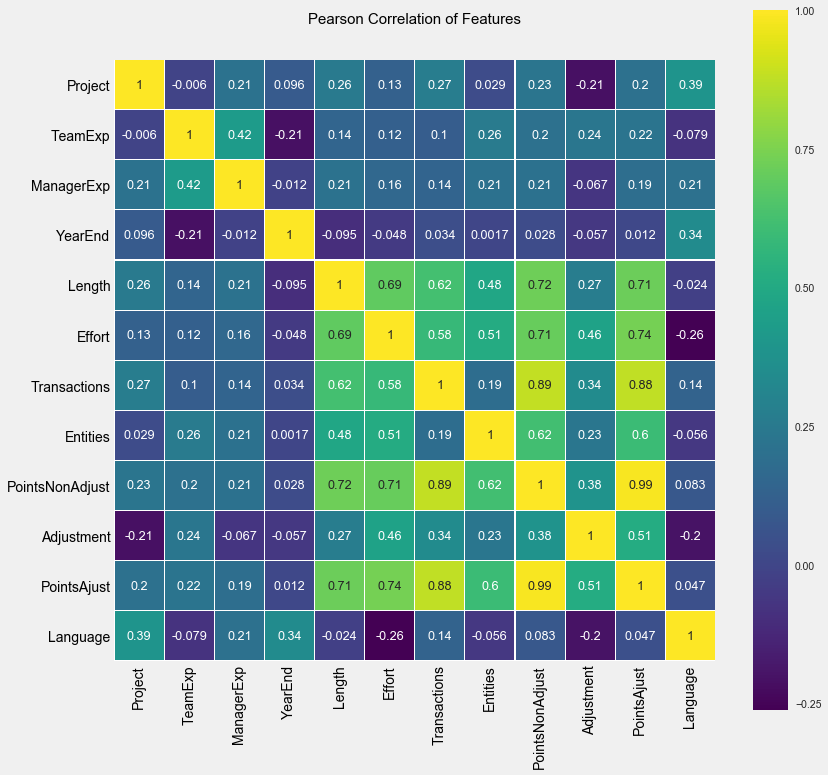

In [10]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.set(font_scale=1.05)
sns.heatmap(df_desharnais.drop(['id'], axis=1).astype(float).corr(),linewidths=0.1,vmax=1.0, square=True,cmap=colormap, linecolor='white', annot=True)

As it can be seen, `Length`, `Transactions`, `Entities`, `PointsAdjust` and `PointsNonAdjust` attributes’ correlation coefficients are above `0.50`. Since correlation coefficient values are greater than `0.50` it means there is a **strong correlation** between dependent and independent variables. Moreover, these attributes p-values are also smaller than 0.05 threshold. So, we can conclude that these attributes are statistically significant

# 2.4.1 - Data Discretization


We have transformed data into new scales using a procedure called Discretisation, to change the problem from regression to classification (i.e. to discretize numeric variables to a number of classes/intervals), it is a very important step to be done because the machine learning techniques we have picked work only with categorized data and do not predict exact numeric values but one of the classes, we used a code in matlab to convert the actual effort taken from the datasets to a specific number or label (1 to 5) according to an experiment done by Radlinski & Hoffmann.



In [11]:
df_desharnais['EffortBand'] = pd.qcut(df_desharnais['Effort'], 10)
df_desharnais[['EffortBand', 'Project']].groupby(['EffortBand'], as_index=False).mean().sort_values(by='EffortBand', ascending=True)


,EffortBand,Project
0,"(545.999, 1267.0]",45.777778
1,"(1267.0, 2174.0]",45.500000
2,"(2174.0, 2548.0]",43.875000
3,"(2548.0, 3136.0]",45.875000
4,"(3136.0, 3647.0]",40.500000
5,"(3647.0, 4067.0]",28.875000
6,"(4067.0, 5635.0]",17.750000
7,"(5635.0, 7252.0]",45.625000
8,"(7252.0, 10577.0]",41.125000
9,"(10577.0, 23940.0]",54.500000


Replacing on dataset:

Text(0,0.5,'Projects')

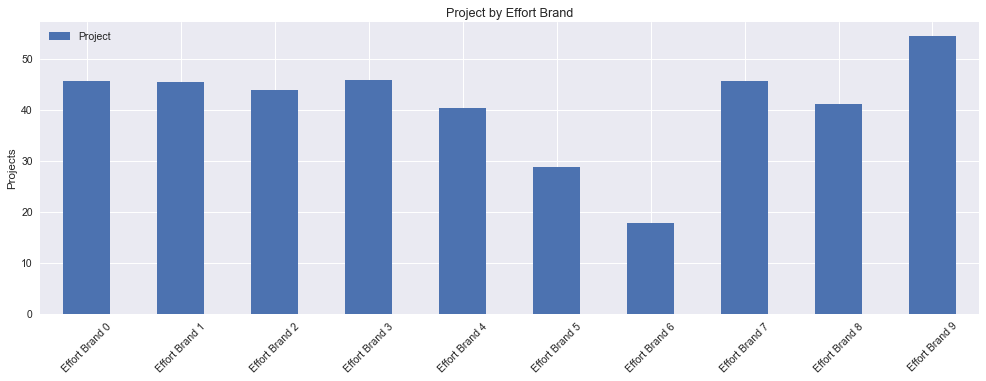

In [12]:
df_desharnais.loc[df_desharnais['Effort'] <= 2174.0, 'EffortClass'] = 0
df_desharnais.loc[ (df_desharnais['Effort'] > 2174.0) & (df_desharnais['Effort'] <= 3136.0), 'EffortClass'] = 1
df_desharnais.loc[ (df_desharnais['Effort'] > 3136.0) & (df_desharnais['Effort'] <= 4067.0), 'EffortClass'] = 2
df_desharnais.loc[ (df_desharnais['Effort'] > 4067.0) & (df_desharnais['Effort'] <= 7252.0), 'EffortClass'] = 3
df_desharnais.loc[df_desharnais['Effort'] > 7252.0, 'EffortClass'] = 4

# df_desharnais.iloc[:,np.r_[6,14]]

# objects = ('Effort Brand 0','Effort Brand 1','Effort Brand 2','Effort Brand 3','Effort Brand 4')
objects = ('Effort Brand 0','Effort Brand 1','Effort Brand 2','Effort Brand 3','Effort Brand 4','Effort Brand 5','Effort Brand 6','Effort Brand 7','Effort Brand 8','Effort Brand 9')

projects = df_desharnais[['EffortBand', 'Project']].groupby(['EffortBand'], as_index=False).mean()
projects.plot(kind='bar', width=0.5, tick_label=objects)
plt.title('Project by Effort Brand')
plt.xticks(np.arange(len(objects)), objects, rotation=45)
plt.ylabel('Projects')


In [13]:
df_desharnais.head()

,id,Project,TeamExp,ManagerExp,YearEnd,Length,Effort,Transactions,Entities,PointsNonAdjust,Adjustment,PointsAjust,Language,EffortBand,EffortClass
0,1,1,1,4,85,12,5152,253,52,305,34,302,1,"(4067.0, 5635.0]",3.0
1,2,2,0,0,86,4,5635,197,124,321,33,315,1,"(4067.0, 5635.0]",3.0
2,3,3,4,4,85,1,805,40,60,100,18,83,1,"(545.999, 1267.0]",0.0
3,4,4,0,0,86,5,3829,200,119,319,30,303,1,"(3647.0, 4067.0]",2.0
4,5,5,0,0,86,4,2149,140,94,234,24,208,1,"(1267.0, 2174.0]",0.0


### 2.4.1.1 - Split Data


In [14]:
from sklearn.cross_validation import train_test_split

# split into train and test
features = [ 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Transactions', 'Entities',
        'PointsNonAdjust', 'Adjustment', 'PointsAjust', 'Effort']

X = df_desharnais[features]
y = df_desharnais['EffortClass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.43, random_state=20)


### 2.4.1.2 - Apply Wrapper using k-NN algorithm (k=3)


In [15]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

try:
    # fitting the model
    knn.fit(X_train, y_train)

    # predict the response
    pred = knn.predict(X_test)

    # evaluate accuracy
    print (classification_report(y_test, pred))
    print("The accuracy of classifier is: {:.2f}".format(accuracy_score(y_test, pred)*100))

except ValueError:
    print('Can\'t have more neighbors than training samples!!')


             precision    recall  f1-score   support

        0.0       1.00      0.78      0.88         9
        1.0       0.71      1.00      0.83         5
        2.0       0.75      1.00      0.86         3
        3.0       0.70      0.88      0.78         8
        4.0       1.00      0.70      0.82        10

avg / total       0.87      0.83      0.83        35

The accuracy of classifier is: 82.86


# 2.4. Algorithm Selection

For deciding the best algorithm in terms of performance measures, we have tried out various AI techniques. They are single learners such as **Linear Regression (LR)**, **Support Vector Regression (SVR)**, **Decision Tree (DT)**, **k-Nearest Neighbor (k-NN)** and **Multilayer Perceptrons (MLP)** and a **Mixture of Experts (MOE)** with all algorithms. These algorithms are selected based on two criteria: 

* a) They are widely used techniques whose performances are validated on various datasets in effort estimation 
* b) From the machine learning perspective, each algorithm can achieve strengths on different datasets based on their regression methodologies


Our methodology for initial model construction can be summarized as follows:

* Select an algorithm from the following set: {LR, SVR, DT, k-NN, MLP, MOE}
* Select a dataset from Table 2. 
    - Apply Wrapper with Exhaustive Search using k-NN algorithm (k=3)
    - Use Leave-One-Out strategy: 
        - Apply the algorithm on dataset 
        - Report MMRE, Pred(25) values
* Apply non-parametric Friedman test to find statistical differences between algorithms. This statistical test checks the null against the alternative hypothesis:

    - "H0: Performance differences among algorithms are random"

    - "H1: Performance differences among algorithms are not random."

## 2.4.2 - Linear Regression

In [16]:
# split into train and test
model = LinearRegression()

features = [ 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Transactions', 'Entities',
        'PointsNonAdjust', 'Adjustment', 'PointsAjust']

max_corr_features = ['Length', 'Transactions', 'Entities','PointsNonAdjust','PointsAjust']

X = df_desharnais[max_corr_features]
y = df_desharnais['Effort']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)

### 2.4.1.1 - Make Predictions

In [17]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print ("Estimated intercept coefficient: ", model.intercept_)
print ("Number of coefficients: ", len(model.coef_))

Estimated intercept coefficient:  -359.6524390466866
Number of coefficients:  5


r-squared training data score:  0.8287968731842215
r-squared test data score:  -0.42859261572258167


Text(0,0.5,'Predictions')

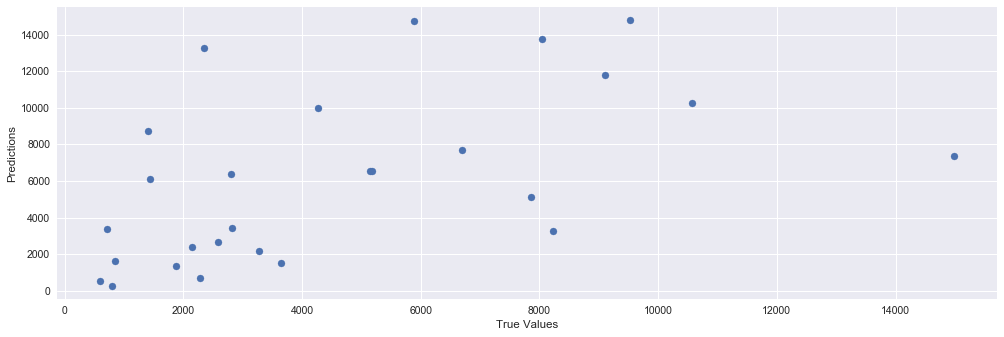

In [18]:
print ("r-squared training data score: ", model.score(X_train, y_train))
print ("r-squared test data score: ", model.score(X_test, y_test))

# print(metrics.r2_score(y, y_pred))

plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

#### 2.4.1.1.1 - Use leave-one-out strategy

R² Score: 0.14963965789201072


Text(0,0.5,'Predictions')

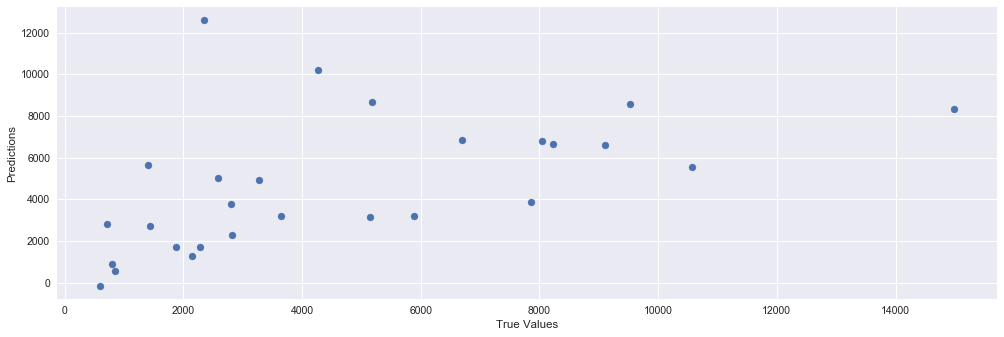

In [19]:
loo = LeaveOneOut()
y_pred = cross_val_predict(model, X_test, y_test, cv=loo.get_n_splits(X_test))

print("R² Score: {}".format(r2_score(y_test, y_pred)))

plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

#### 2.4.1.1.2 - Apply the algorithm on dataset

R² Score: 0.5260994773160591


Text(0,0.5,'Predictions')

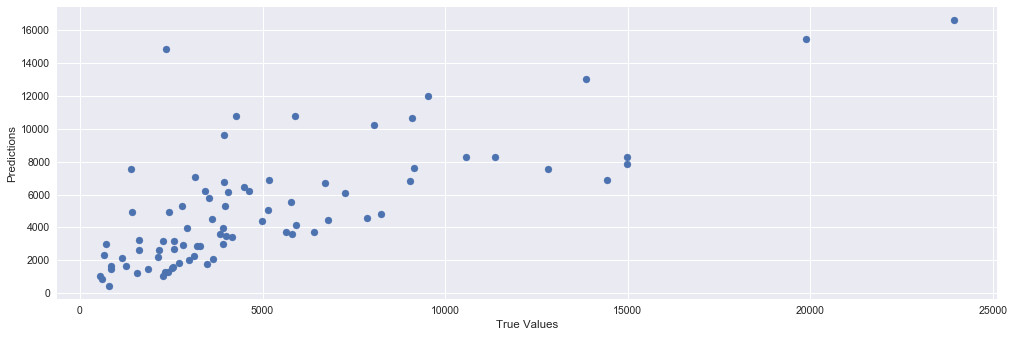

In [20]:
loo = LeaveOneOut()
y_pred = cross_val_predict(model, X, y, cv=loo.get_n_splits(X_test))

print("R² Score: {}".format(r2_score(y, y_pred)))

plt.scatter(y, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

#### 2.4.1.1.3 - Report MSE, MMRE, Pred(25) values

The Mean Squared Error (MSE) is a measure of how close a fitted line is to data points. For every data point, you take the distance vertically from the point to the corresponding y value on the curve fit (the error), and square the value. Then you add up all those values for all data points, and, in the case of a linear fit, divide by the number of points minus two.** The squaring is done so negative values do not cancel positive values. The smaller the Mean Squared Error, the closer the fit is to the data. The MSE has the units squared of whatever is plotted on the vertical axis.

Another quantity that we calculate is the Root Mean Squared Error (RMSE). It is just the square root of the mean square error. That is probably the most easily interpreted statistic, since it has the same units as the quantity plotted on the vertical axis.

In [21]:
print ("MSE: {}".format(mean_squared_error(y, y_pred)))

MSE: 9138910.087993171


A residual value is a measure of how much a regression line vertically misses a data point. Regression lines are the best fit of a set of data. You can think of the lines as averages; a few data points will fit the line and others will miss. A residual plot has the Residual Values on the vertical axis; the horizontal axis displays the independent variable.

The residual is defined as the difference between the observed height of the data point and the predicted value of the data point using a prediction equation. If the data point is above the graph of the prediction equation, the residual is positive. If the data point is below the graph of the predicted equation, the residual is negative, and if the data point is on the graph of the prediction equation the residual is zero.

When you model data with an equation, the data does not always go, or sometimes never goes, through all of the data points. The residual plot is a representation of how close each data point is vertically from the graph of the prediction equation from the model. It even shows if the data point is above or below the graph of the prediction equation of the model that is supposed to be best fit for the data.

Text(0,0.5,'Residuals')

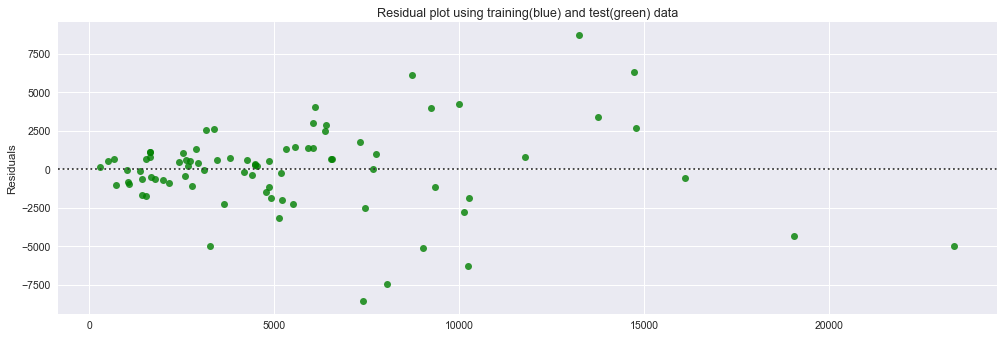

In [22]:
sns.residplot(model.predict(X), model.predict(X) - y, lowess=False, color="g")
# sns.residplot(model.predict(X_train), model.predict(X_train) - y_train, lowess=False, color="b")
# sns.residplot(model.predict(X_test), model.predict(X_test) - y_test, lowess=False, color="r")
plt.title("Residual plot using training(blue) and test(green) data")
plt.ylabel("Residuals")

Conte, Dunsmore, and Shen suggest that an acceptable value of `MRE` is a value less or equal 0.25. They use this notion to define a mesure of prediction quality by defining an estimation technique to be acceptable if PRED(0.25) is at least 0.75, where

`PRED(q) = k / n`

and `k` is the number of projects whose `MRE` is less than or equal to `q`.

The criterion used to evaluate the predictive quality of an estimation model was `PRED (l) = k/n`, where `k` is the number of projects in a specific sample of size `n` for which `MRE <= l`. In the software engineering literature, an estimation model is considered good when PRED (0.25) = 0.75 [17] or  PRED (0.30) = 0.70 and PRED (0.20) = 0.80 [10]. PRED (0.25) = 0.75 means 75% of the samples should have MRE values less than or equal to 0.25. While an MRE error level in 75% of the population less than 0.25 is the expectation of this criterion, multi-organiza- tional data such as in ISBSG data exhibit large MRE for 75% of the population. 

[Estimation Models for Software Functional Test Effort](https://www.researchgate.net/publication/316537863_Estimation_Models_for_Software_Functional_Test_Effort [accessed May 20 2018]).

In [23]:
mre_values = ((y - model.predict(X))/y)

df_desharnais['MRE'] = mre_values
print ("MMRE: {}".format(df_desharnais['MRE'].mean()))
df_desharnais.head()

MMRE: -0.3633024896425575


,id,Project,TeamExp,ManagerExp,YearEnd,Length,Effort,Transactions,Entities,PointsNonAdjust,Adjustment,PointsAjust,Language,EffortBand,EffortClass,MRE
0,1,1,1,4,85,12,5152,253,52,305,34,302,1,"(4067.0, 5635.0]",3.0,-0.270041
1,2,2,0,0,86,4,5635,197,124,321,33,315,1,"(4067.0, 5635.0]",3.0,0.138381
2,3,3,4,4,85,1,805,40,60,100,18,83,1,"(545.999, 1267.0]",0.0,0.628023
3,4,4,0,0,86,5,3829,200,119,319,30,303,1,"(3647.0, 4067.0]",2.0,-0.167702
4,5,5,0,0,86,4,2149,140,94,234,24,208,1,"(1267.0, 2174.0]",0.0,-0.128956


In [24]:
df_to_pred = df_desharnais[df_desharnais['MRE'] > 0.25]
print ("Pred(30): {:.2f}".format(df_to_pred.size/df_desharnais.size))

Pred(30): 0.26


## 2.4.2 - KNeighborsRegressor

In [25]:
# split into train and test
neigh = KNeighborsRegressor(n_neighbors=3)

features = [ 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Transactions', 'Entities',
        'PointsNonAdjust', 'Adjustment', 'PointsAjust']

max_corr_features = ['Length', 'Transactions', 'Entities','PointsNonAdjust','PointsAjust']

X = df_desharnais[features]
y = df_desharnais['Effort']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)

In [26]:
neigh.fit(X_train, y_train) 
print(neigh.score(X_test, y_test))

-0.7569805388155932


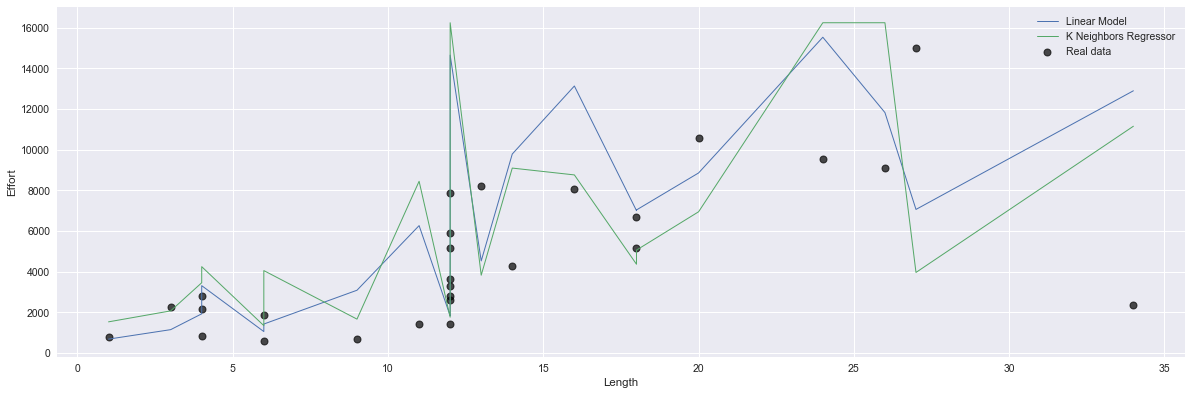

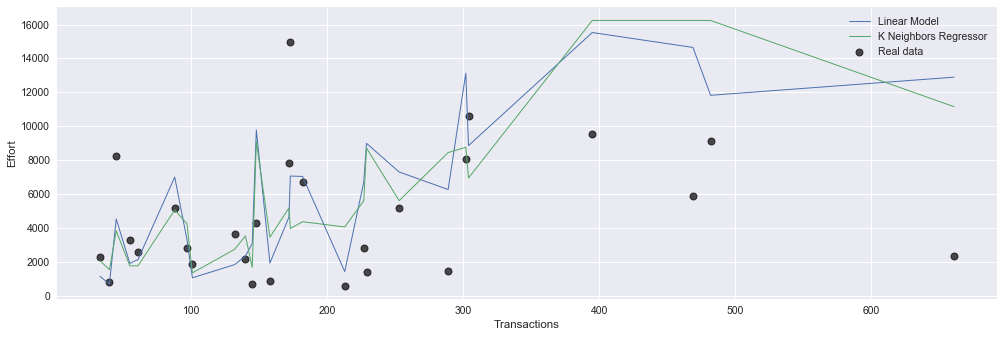

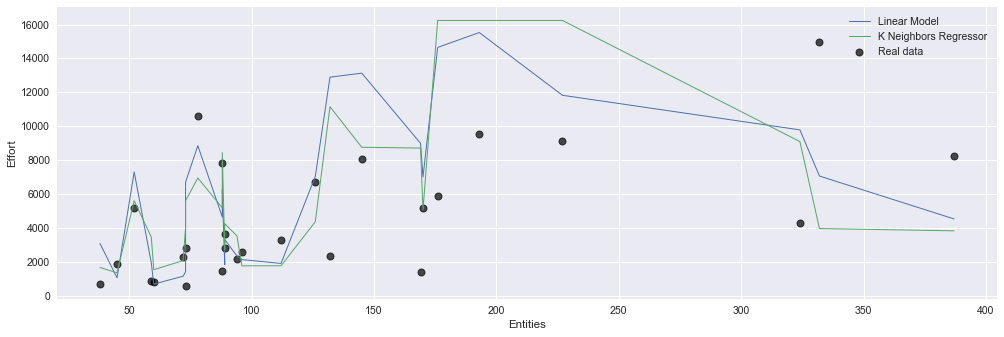

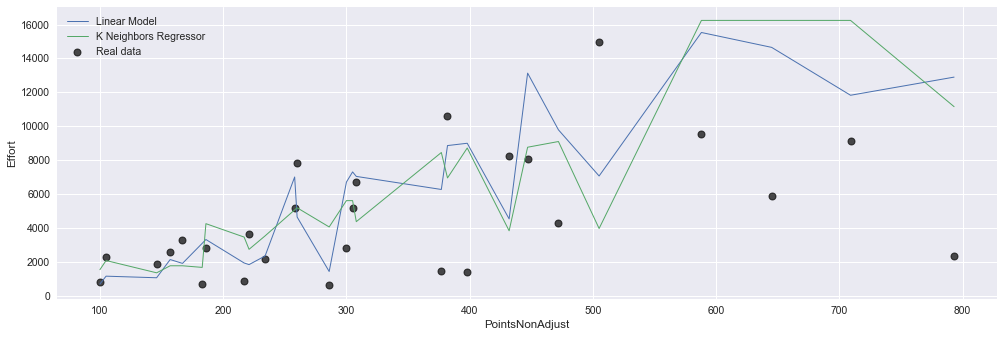

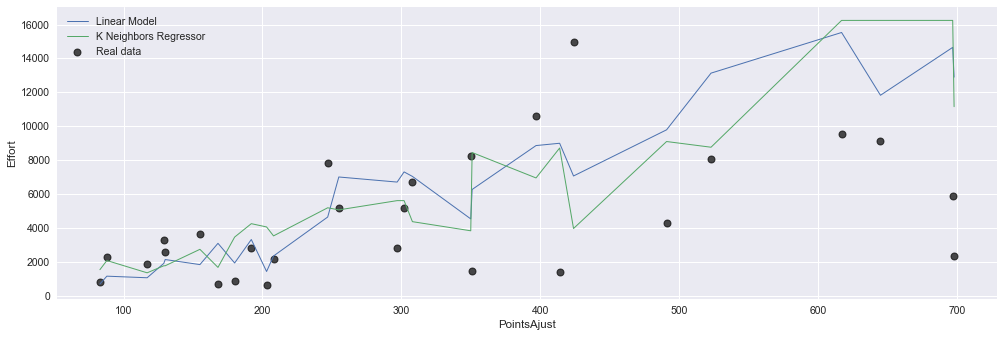

In [27]:
max_corr_features = ['Length', 'Transactions', 'Entities','PointsNonAdjust','PointsAjust']

plt.figure(figsize=(18,6))

for i, feature in enumerate(max_corr_features):
   
    xs, ys = zip(*sorted(zip(X_test[feature], neigh.fit(X_train, y_train).predict(X_test))))
    
    model_xs, model_ys = zip(*sorted(zip(X_test[feature], model.fit(X_train, y_train).predict(X_test))))

    
    plt.scatter(X_test[feature], y_test, label='Real data', lw=1,alpha= 0.7, c='k' )
    plt.plot(model_xs, model_ys , lw=1, label='Linear Model')
    plt.plot(xs, ys , lw=1,label='K Neighbors Regressor')
    plt.xlabel(feature)
    plt.ylabel('Effort')
    plt.legend()
    plt.show()